# 1. Überblick

In [1]:
%run 'KPI Übersicht - helper.ipynb'

### Letztes Update: 2023-07-20

### Hinweis zu Zahlen über Lehrkräfte:
Die Anzahl der Lehrkräfte gibt die Anzahl an User:innen wieder, die bei der Anmeldung angegeben haben, dass sie Lehrkräfte sind. Nicht alle User:innen haben dies angegeben und zum Teil sind diese Daten veraltet.

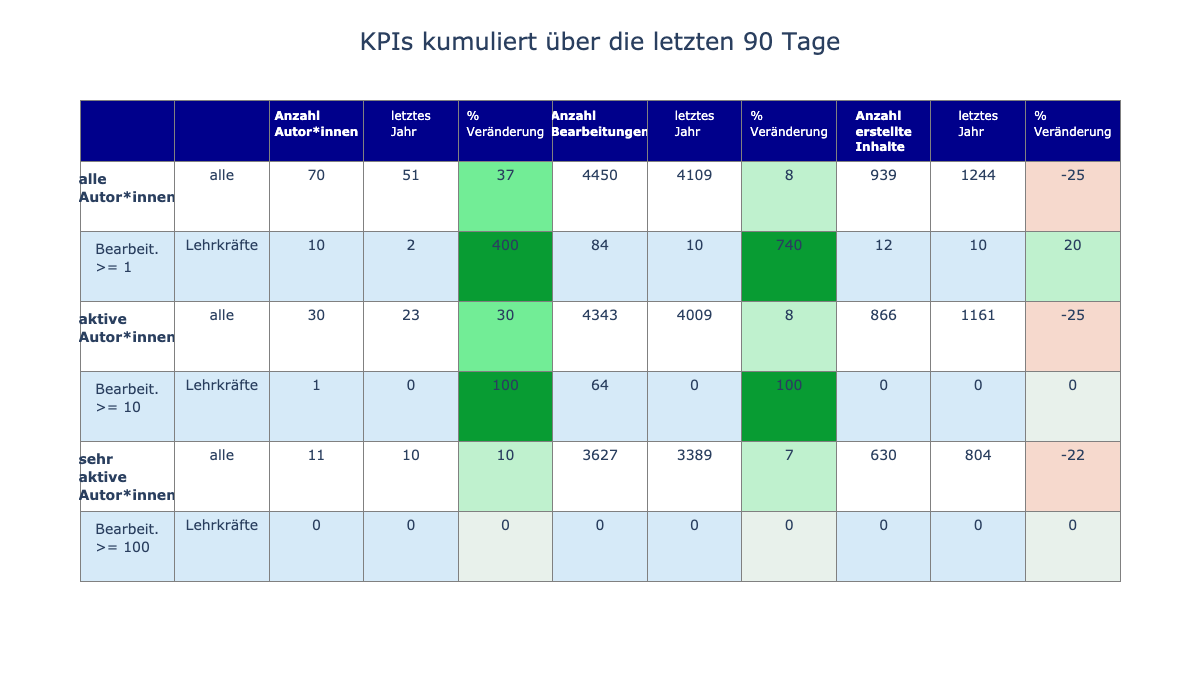

In [2]:
create_kpi_table()

# 2. Anzahl Autor*innen

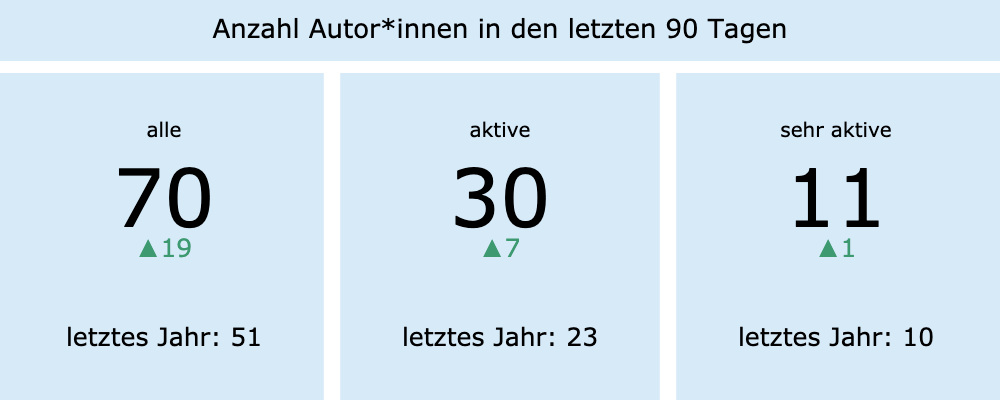

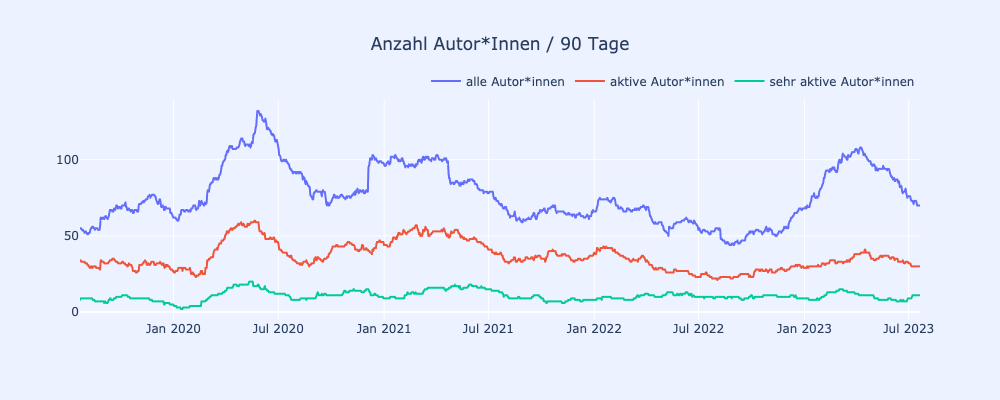

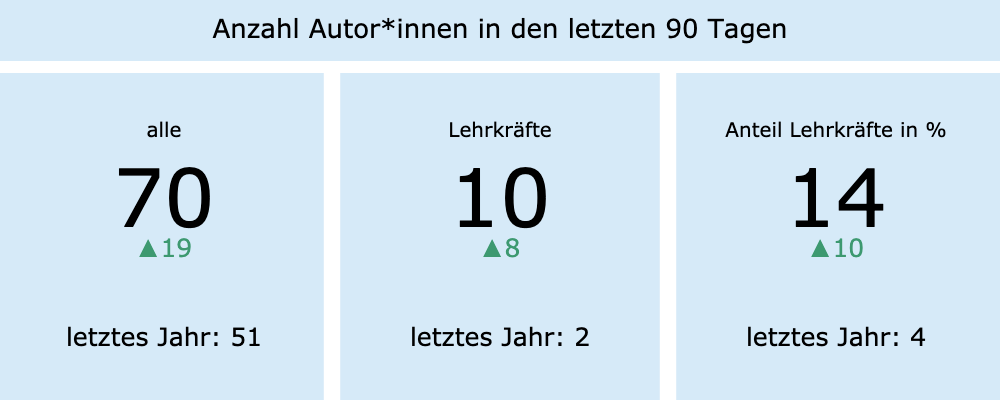

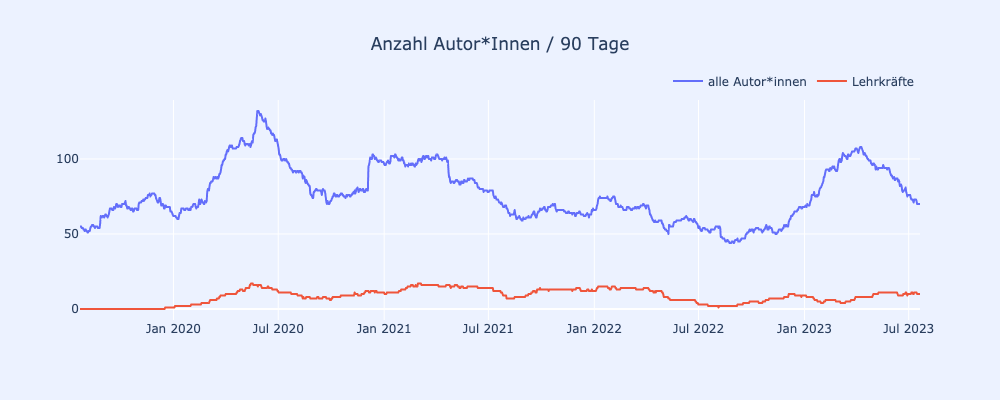

# Neue Autor*innen in den letzten 90 Tagen

,username,edits,interest,first_appearance,subjects,first_appearance_in_last_90_days
0,MGoeldner,64,teacher,2020-09-30,Prüfungsbereich Mathematik,2023-06-25
1,wdihgefhgflj,17,,2023-05-05,Mathe,2023-05-05
2,Muutos,9,,2020-08-05,"Testbereich!, Lerntipps, Nachhaltigkeit",2023-04-25
3,Lavanya,8,,2021-09-16,à®à®²à®à¯à®à®£à®®à¯,2023-05-30
4,Yummy,6,,2023-05-16,Mathe,2023-05-16
5,Hager,6,teacher,2022-09-06,Mathe,2023-04-29
6,Leumas,5,,2023-07-05,"Latein, Informatik",2023-07-05
7,atmflow,5,,2023-06-05,Mathe,2023-06-05
8,Par145qv,3,,2023-05-05,Mathe,2023-05-05
9,Menuja,3,,2019-07-13,"à®à®²à®à¯à®à®£à®®à¯, Community, à®µà®°à®²...",2023-05-22


In [3]:
create_kpi_figure('Anzahl Autor*innen in den letzten 90 Tagen', get_number_of_all_authors)
create_time_chart(title="Anzahl Autor*Innen / 90 Tage", get_data_func=get_number_of_all_authors, split="activity")
create_kpi_figure('Anzahl Autor*innen in den letzten 90 Tagen', get_number_of_all_authors, split='interest')
create_time_chart(title="Anzahl Autor*Innen / 90 Tage", get_data_func=get_number_of_all_authors, split="interest")
display(Markdown("# Neue Autor*innen in den letzten 90 Tagen"))
display(get_list_of_new_authors())

# 3. Anzahl Bearbeitungen

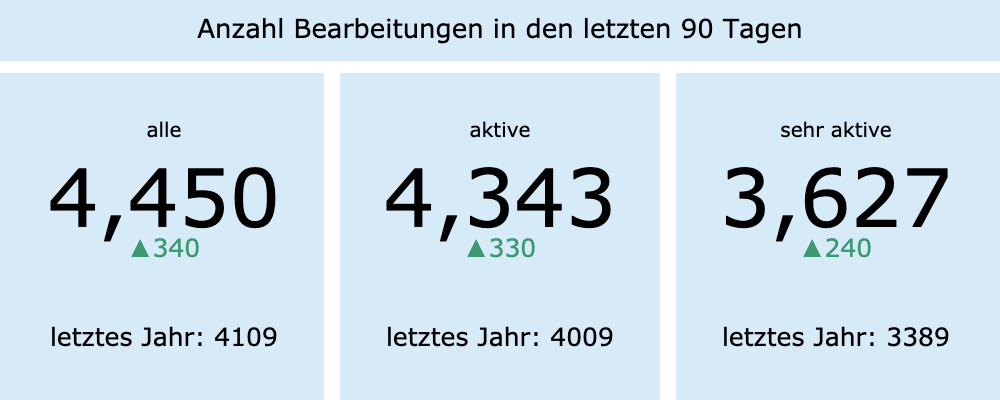

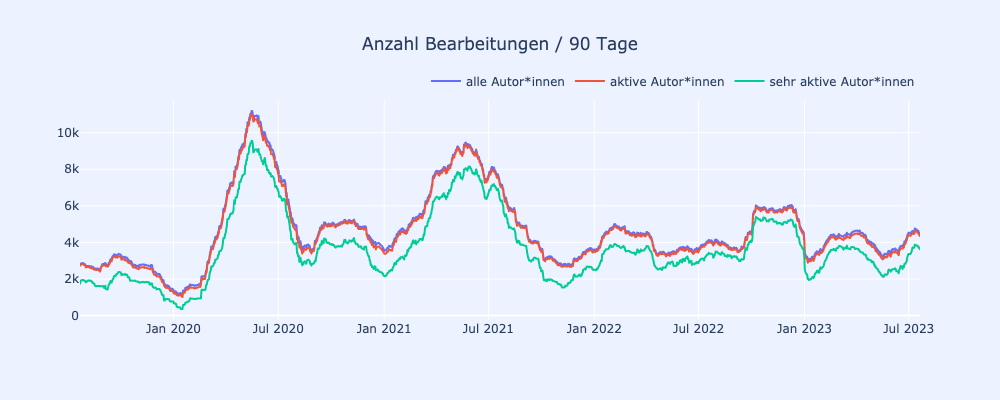

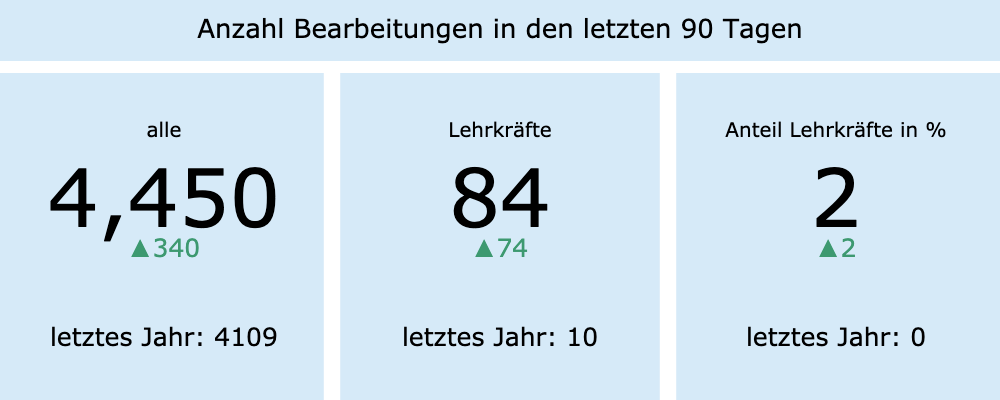

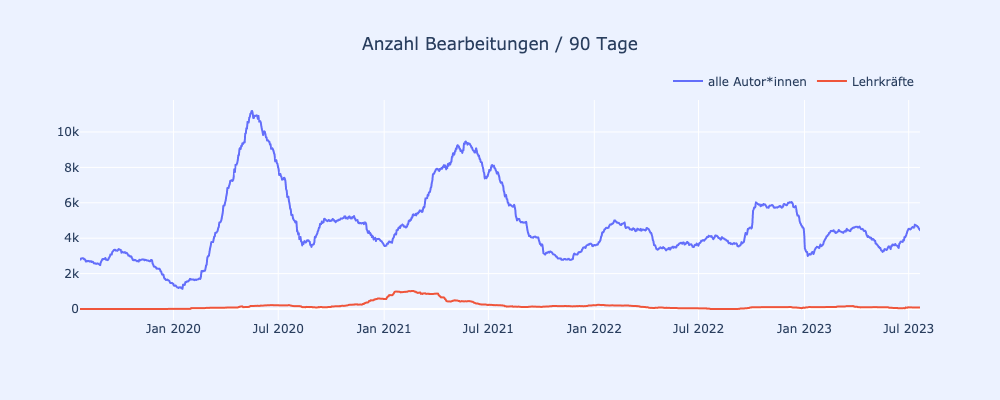

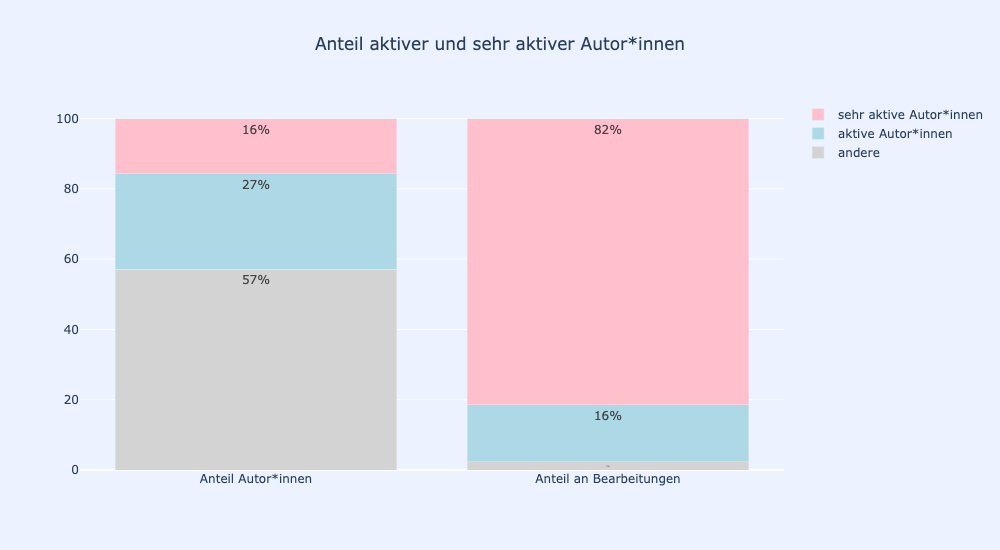

## 16% sehr aktive Autor*innen sind für 82% aller Bearbeitungen verantwortlich.

# Top Autor*Innen

,username,edits
0,Felix_Eccardt,1489
10,others,924
1,Nadine_Gabel,556
2,Kowalsky,395
3,Karin,243
4,metzgaria,225
5,Sascha_Lill_95,164
6,driedger,124
7,Peter,113
8,Annika-Hemlein,111


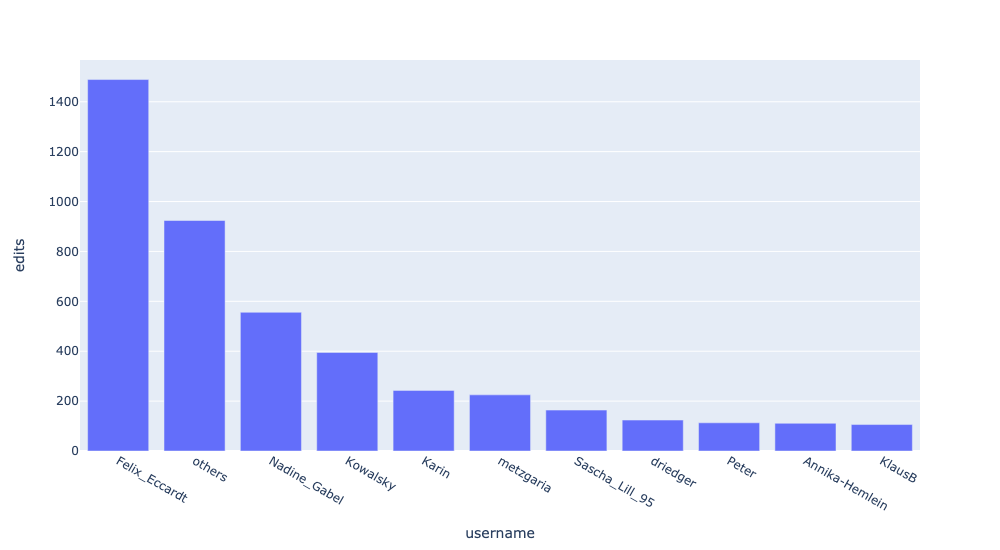

# Top Autor*Innen vor einem Jahr

,username,edits
0,Felix_Eccardt,979
10,others,720
1,Kowalsky,577
2,Karin,492
3,LinaMaria,488
4,metzgaria,180
5,kathongi,150
6,botho,150
7,Selin_11,144
8,Annika-Hemlein,126


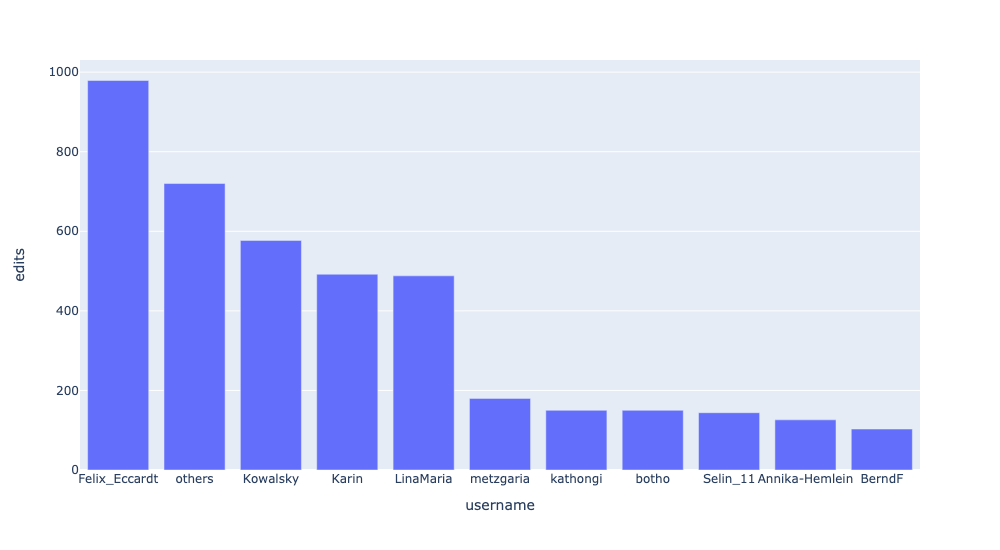

In [4]:
create_kpi_figure('Anzahl Bearbeitungen in den letzten 90 Tagen', get_number_of_all_edits)
create_time_chart(title="Anzahl Bearbeitungen / 90 Tage", get_data_func=get_number_of_all_edits, split="activity")
create_kpi_figure('Anzahl Bearbeitungen in den letzten 90 Tagen', get_number_of_all_edits, split='interest')
create_time_chart(title="Anzahl Bearbeitungen / 90 Tage", get_data_func=get_number_of_all_edits, split="interest")
create_share_graph(get_data_func=get_number_of_all_edits, split='activity')
display(Markdown(f'## {round((get_number_of_all_authors(edits=100)*100)/get_number_of_all_authors(edits=1))}% sehr aktive Autor*innen sind für {round((get_number_of_all_edits(edits=100)*100)/get_number_of_all_edits(edits=1))}% aller Bearbeitungen verantwortlich.'))
display(Markdown("# Top Autor*Innen"))
display(get_top_authors())
create_top_author_chart()
display(Markdown("# Top Autor*Innen vor einem Jahr"))
display(get_top_authors(year=1))
create_top_author_chart(year=1)

# 4. erstellte Inhalte

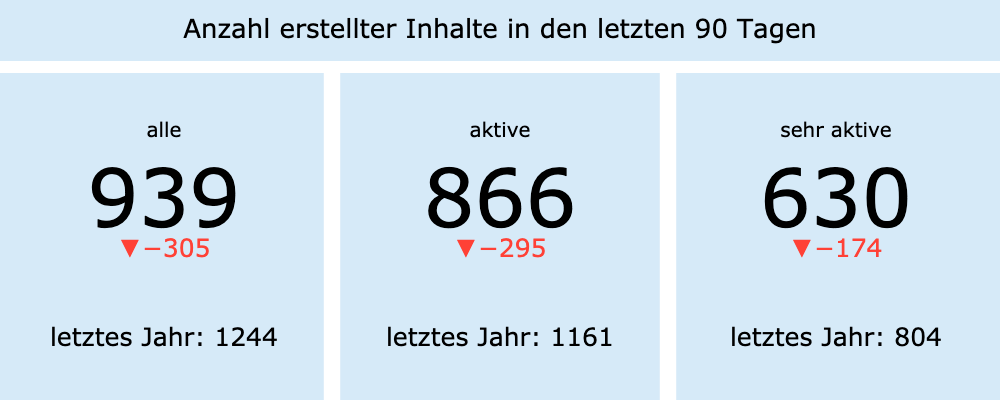

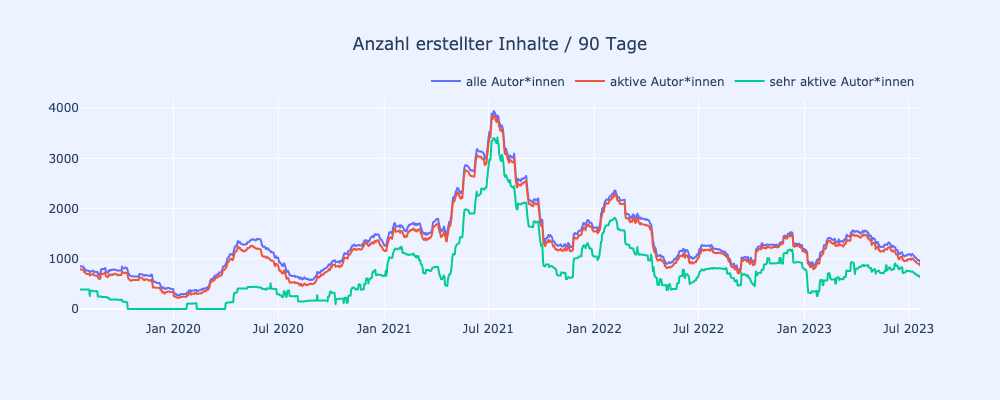

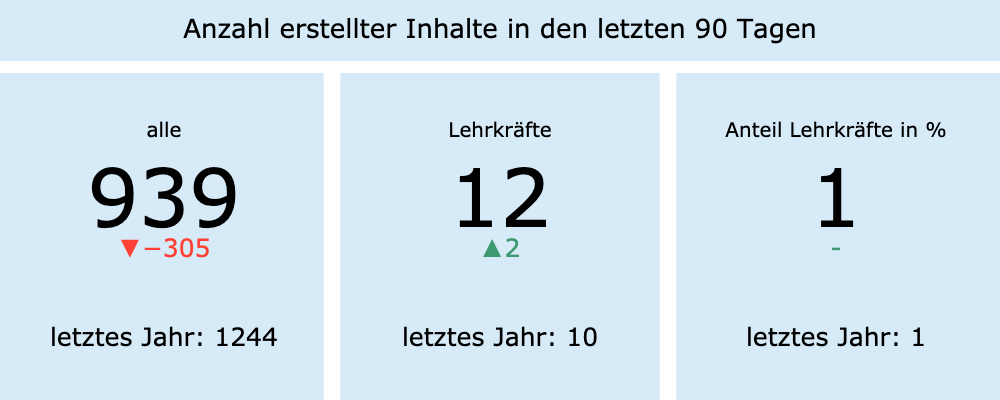

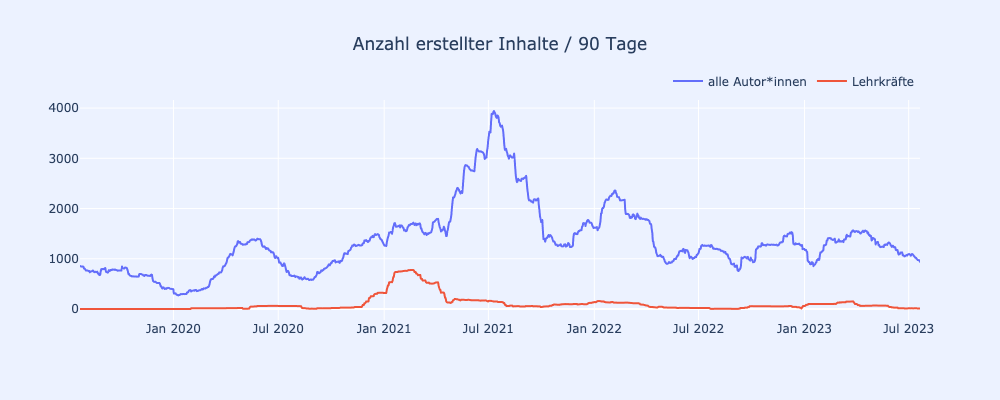

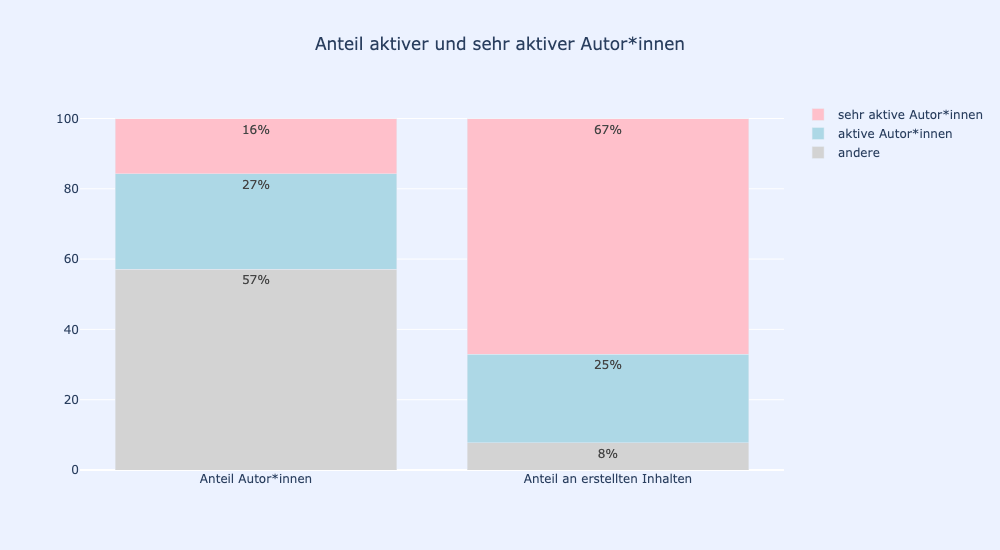

In [5]:
create_kpi_figure('Anzahl erstellter Inhalte in den letzten 90 Tagen', get_number_of_created_contents)
create_time_chart(title="Anzahl erstellter Inhalte / 90 Tage", get_data_func=get_number_of_created_contents, split="activity")
create_kpi_figure('Anzahl erstellter Inhalte in den letzten 90 Tagen', get_number_of_created_contents, split='interest')
create_time_chart(title="Anzahl erstellter Inhalte / 90 Tage", get_data_func=get_number_of_created_contents, split="interest")
create_share_graph(get_data_func=get_number_of_created_contents, split='activity')